In [1]:
!pip install -U datasets[audio]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 27.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [2]:
! pip install torchaudio

In [3]:
!pip install torchcodec

In [4]:
import librosa
import numpy as np
import pandas as pd
import IPython.display as ipd

In [5]:
import torchcodec

In [6]:
from datasets import load_dataset, Audio

In [7]:
SR = 32000 # SAMPLE RATE

In [8]:
ds = load_dataset("zahidpichen/violine_dataset")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/120 [00:00<?, ?B/s]

violine_dataset/train/audio_1.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/train/audio_2.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/train/audio_3.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/train/audio_4.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/test/audio_5.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

violine_dataset/test/audio_6.mp3:   0%|          | 0.00/361k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2 [00:00<?, ? examples/s]

In [11]:
sample = ds['train'][0]['audio']

In [28]:
import matplotlib.pyplot as plt
import librosa.display
import librosa # Added librosa import for frames_to_time

def plot_spect(spectrogram,mode='mel'):
  """
  Mode options:
    - 'linear', 'fft', 'hz': Displays frequencies on a linear scale, determined by the FFT window and sampling rate.
    - 'log': Displays frequencies on a logarithmic scale.
    - 'mel': Displays frequencies on the Mel scale, often used for representing human perception of pitch.
    - 'cqt_hz': Displays frequencies based on the Constant-Q Transform (CQT) in Hz.
    - 'cqt_note': Displays pitches based on the CQT, labeled with musical note names (e.g., C1, G#2)
  """
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spectrogram, sr=SR, x_axis='time', y_axis=mode)
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'{mode.capitalize()} Spectrogram')
  plt.tight_layout()
  plt.show()

def plot_signal(signal):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(signal, sr=SR)
  plt.title('Audio Waveform')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.tight_layout()
  plt.show()

def plot_signal_with_onsets(signal, onsets_frames, sr, hop_length=512):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(signal, sr=sr)
  plt.title('Audio Waveform with Onsets')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')

  # Convert onset frames to time
  onset_times = librosa.frames_to_time(onsets_frames, sr=sr, hop_length=hop_length)

  # Plot vertical lines at onset times
  for time in onset_times:
    plt.axvline(x=time, color='r', linestyle='--', alpha=0.8)

  plt.tight_layout()
  plt.show()

# Onset Detection

In [14]:
signal = sample['array']

In [16]:
HOP = SR // 2

In [81]:
signal

array([0.        , 0.        , 0.        , ..., 0.08539715, 0.07609099,
       0.05157228], dtype=float32)

In [83]:
onset = librosa.onset.onset_detect(y=signal,
                           sr=SR,
                           hop_length=512,
                           units='frames',
                           normalize=True, # Key for having good results
                           sparse=True)

In [48]:
onset

array([ 243,  248,  445,  464,  484,  501,  520,  536,  547,  558,  573,
        695,  788,  795,  805,  822,  838,  856,  888,  895,  907,  912,
        990, 1000, 1008, 1025, 1042, 1067, 1080, 1096, 1138, 1174, 1343,
       1350, 1365, 1383, 1464, 1511, 1543, 1589, 1629, 1674, 1804, 1859])

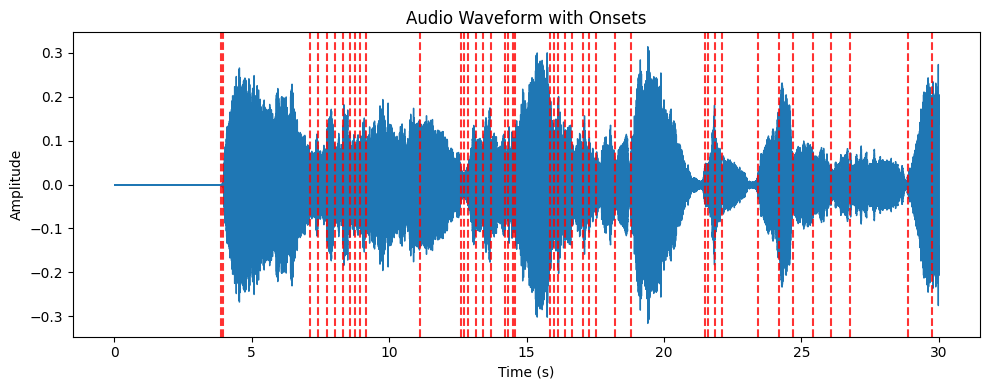

In [84]:
plot_signal_with_onsets(signal, onset, SR, hop_length=512)

In [12]:
ipd.Audio(sample['array'], rate=SR)

As we can see, it manages to detect some onsets, but misses many others. Particularly, when a fast run of notes begins after a long, held note, it fails to detect the onset because the note's attack is masked by the preceding note.

## Filtering results

In [74]:
# Signal duration (seconds)
print(f"{len(signal)/SR} sec")

30.0 sec


In [62]:
# Sample duration
sample_length = 1/SR*1000
print(f"{sample_length:.5f} ms")

0.03125 ms


In [88]:
# Samples window for avoiding onset detections
threshold = 50
print(f"{threshold*sample_length:.5f} ms")

1.56250 ms


In [89]:
if len(onset) > 0:
    filtering = [onset[0]] # Always keep the first onset
    for i in range(1, len(onset)):
        # If the current onset is at least 'threshold' frames away from the last accepted onset
        if onset[i] - filtering[-1] >= threshold:
            filtering.append(onset[i])
    filtered_onset = np.array(filtering) # Update the 'onset' variable
else:
    onset = np.array([]) # If original onset was empty, filtered_onsets is also empty

In [90]:
filtered_onset

array([ 243,  445,  501,  558,  695,  788,  838,  888,  990, 1042, 1096,
       1174, 1343, 1464, 1543, 1629, 1804, 1859])

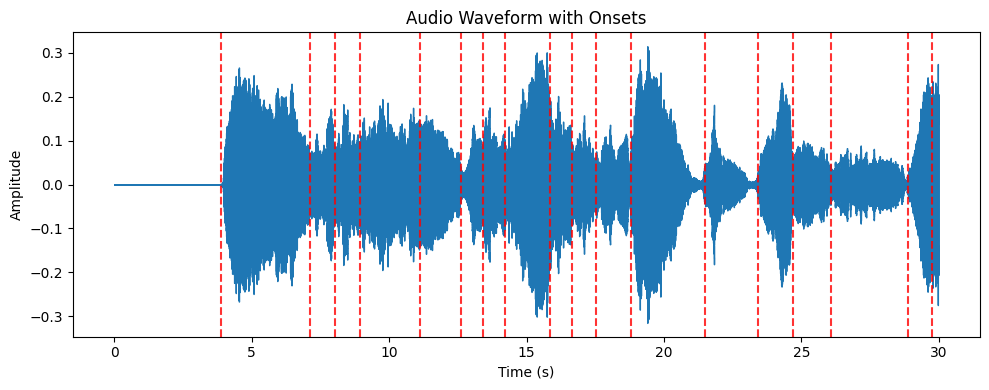

In [91]:
plot_signal_with_onsets(signal, filtered_onset, SR, hop_length=512)

In [93]:
ipd.Audio(sample['array'], rate=SR)

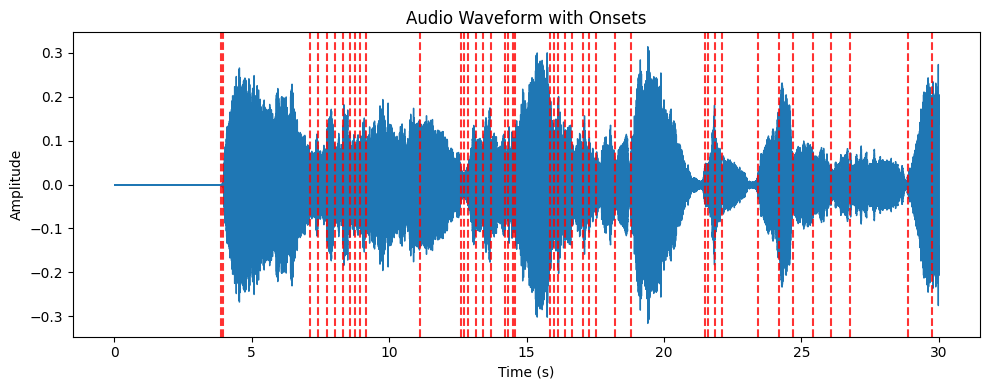

In [92]:
plot_signal_with_onsets(signal, onset, SR, hop_length=512)